# Investigate Agenda Setting

In [243]:
import os
if not os.environ.get("PREAMBLE_RUN", False): 
    %run -i 'preamble.py'

In [244]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from src.constants import PATH_ALL_SPEECHES, PATH_MIGRATION_SPEECHES_EMBEDDED, COLOR_MAPS, MIGRATION_THRESHOLD

In [ ]:
df_final = pd.read_parquet(PATH_ALL_SPEECHES)
final_topic_col = "migration_prob"
final_threshold = MIGRATION_THRESHOLD
party_column = "block" # "party"

colormap = COLOR_MAPS[party_column]

In [246]:
df_migration = pd.read_parquet(PATH_MIGRATION_SPEECHES_EMBEDDED)

In [248]:
# only the speeches that are classified as migration 
df_migration_speeches = df_final[df_final[final_topic_col] >= final_threshold]

# full debates where at least one speech is migration related
df_all_speeches_with_one_migration_in_agenda = df_final[df_final["agenda"].isin(df_migration_speeches["agenda"])]

In [249]:
def print_agendas(agenda_items, first_k=3):
    """
    For each agenda item of the first k in agenda_items:
    Print the debates of the agenda items, by printing
    Agenda title etc.
    [{x if classfied as migration}] {speechnumber}: {speaker} {party block} {migration score} \n speech
    """
    for agenda in agenda_items[:first_k]: 
        df_agenda = df_final[df_final["agenda"] == agenda]
        print(agenda)
        
        migration_contributions = df_agenda[df_agenda[final_topic_col] > final_threshold]

        print("Parties talking about migration:", ', '.join (f'{b} ({n})' for b, n in migration_contributions[party_column].value_counts().items()))
        for _, row in df_agenda.iterrows():
            migration_score = row[final_topic_col]
            marker_is_migration = "[x]" if migration_score > final_threshold else "[ ]"

            translatedText = row["translatedText"].replace("\n", "\n\t")
            print(f'{marker_is_migration} {row["speechnumber"]}: {row["speaker"]} ({row["party"]} - {row["block"]}) [{int(migration_score*100)}% migration]\n\t{translatedText}')

        print("="*50, "end of agenda item", "="*50)

In [250]:
def entropy(values): 
    # Compute the shannon entropy of the value series
    total = len(values)

    probs = np.array([n/total for _, n in values.value_counts().items()])
    log_probs = np.log2(probs)
    return - (probs * log_probs).sum()

def effective_number_of_parties(values): 
    # Compute the effective number of parties (https://en.wikipedia.org/wiki/Effective_number_of_parties)
    probs = np.array(values.value_counts(normalize=True))
    return 1 / (probs * probs).sum()

migration_speeches_grouped_by_agenda = df_migration_speeches.groupby("agenda").agg(
    party_entropy_migration = pd.NamedAgg(party_column, entropy), 
    n_parties_migration = pd.NamedAgg(party_column, lambda x: len(set(x))),
    parties_migration = pd.NamedAgg(party_column, set), 
    n_speeches_migration = pd.NamedAgg("translatedText", len),
    effective_n_parties_migration = pd.NamedAgg(party_column, effective_number_of_parties),
)
all_speeches_grouped_by_agenda = df_all_speeches_with_one_migration_in_agenda.groupby("agenda").agg(
    party_entropy = pd.NamedAgg(party_column, entropy), 
    n_parties = pd.NamedAgg(party_column, lambda x: len(set(x))),
    parties = pd.NamedAgg(party_column, set), 
    n_speeches = pd.NamedAgg("translatedText", len),
    avg_migration_score = pd.NamedAgg(final_topic_col, "mean"),
    effective_n_parties = pd.NamedAgg(party_column, effective_number_of_parties),
    date = pd.NamedAgg("date", "first"), # assume the date is the same for all agenda items, 
    year = pd.NamedAgg("year", "first") 
)

# dataframe created has per agenda item:
# 'party_entropy[_migration]': entropy of parties talking about this agenda item [about migration]
# 'n_parties[_migration]': number of parties ... 
# 'effective_n_parties[_migration]'
# 'parties[_migration]': list of parties ... 
# 'n_speeches[_migration]': number of speeches in this agenda item [about migration]
# 'avg_migration_score': average migration score of the speeches
# proportion_migration_speeches

migration_agendas = all_speeches_grouped_by_agenda.join(migration_speeches_grouped_by_agenda)
migration_agendas["proportion_migration_speeches"] = migration_agendas["n_speeches_migration"] / migration_agendas["n_speeches"]

In [269]:
len(migration_agendas[migration_agendas["n_speeches_migration"] == 0])

0

## Do parties do agenda-setting?

only considering agenda items with > 5.459389843744717 speeches: 978 of 1054


<Axes: title={'center': 'How many parties (effectively) talk about migration per agenda item? [Frequency]'}, ylabel='Frequency'>

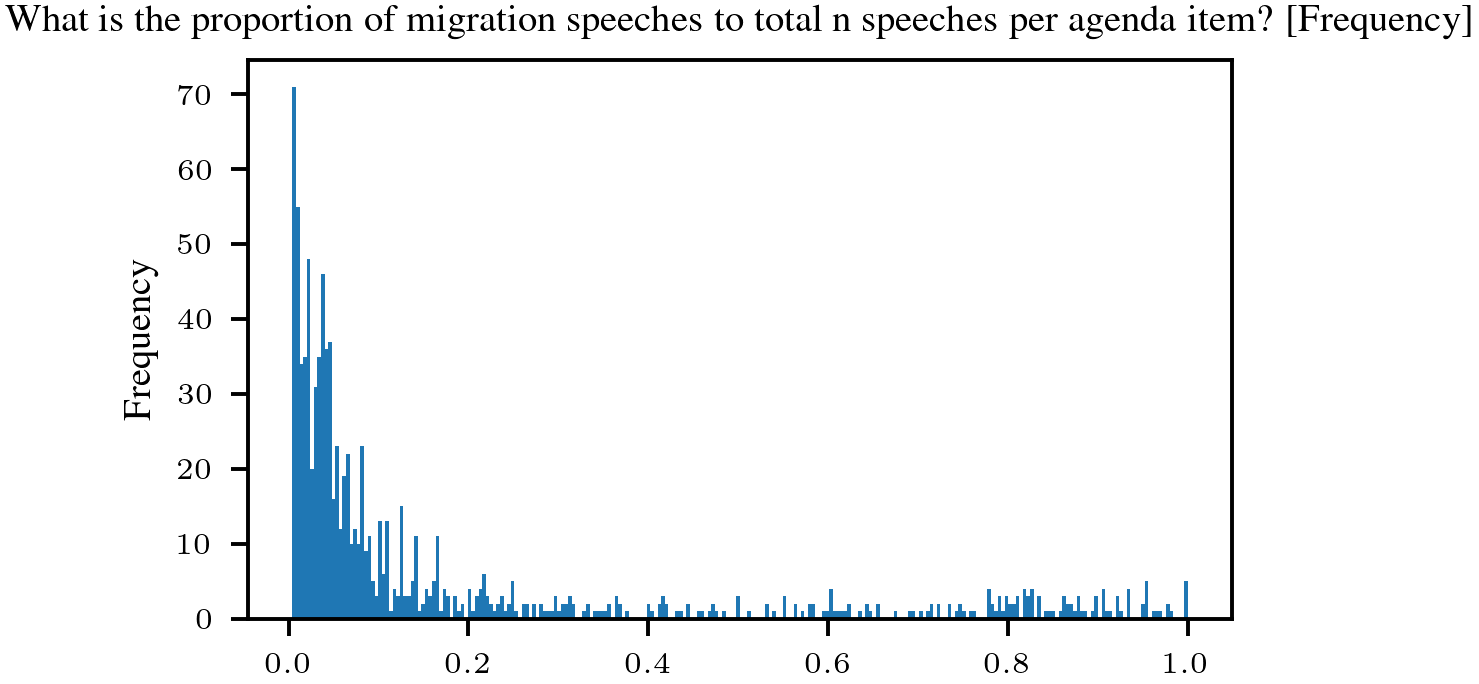

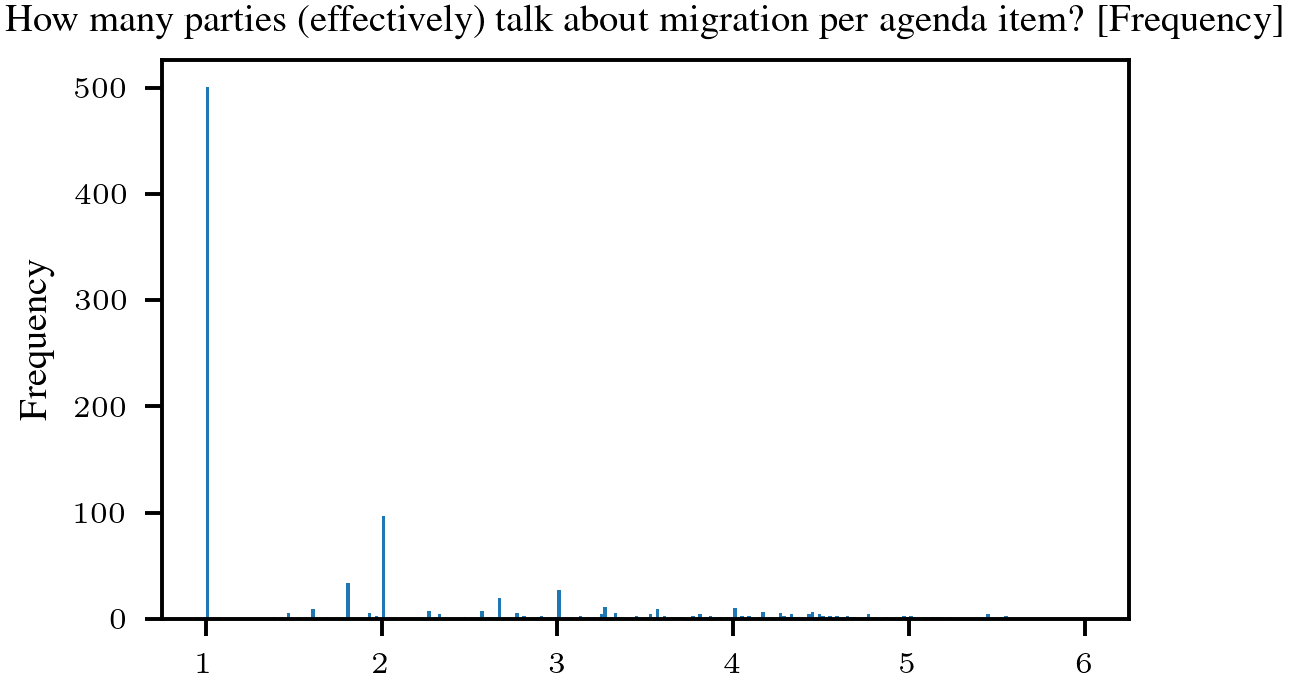

In [270]:
# ignore agenda items with only a few speeches
min_speeches_per_agenda = migration_agendas["n_speeches"].mean() - migration_agendas["n_speeches"].std()

migration_agendas_with_debates = migration_agendas[migration_agendas["n_speeches"] > min_speeches_per_agenda].sort_values("n_speeches")
print("only considering agenda items with >", min_speeches_per_agenda, "speeches:", len(migration_agendas_with_debates), "of", len(migration_agendas))

plt.figure()
migration_agendas_with_debates["proportion_migration_speeches"].plot.hist(bins=250, title="What is the proportion of migration speeches to total n speeches per agenda item? [Frequency]")
plt.figure()
migration_agendas_with_debates["effective_n_parties_migration"].plot.hist(bins=250, title="How many parties (effectively) talk about migration per agenda item? [Frequency]")

In [271]:
agenda_items_with_agenda_setting = (migration_agendas_with_debates[migration_agendas_with_debates["effective_n_parties_migration"] == 1]).index
df_agenda_setting_candidates = df_final[df_final["agenda"].isin(agenda_items_with_agenda_setting)]
print(len(agenda_items_with_agenda_setting),"agenda items with agenda setting")

501 agenda items with agenda setting


In [272]:
def count_migration_speeches(df: pd.DataFrame): 
    return df[df[final_topic_col] > final_threshold].groupby(["block", "year"]).size().unstack(fill_value=0)

# per party: what is the number of speeches that the party is talking about migration, but is the only one (in the agenda items where there is a debate)
n_migration_speeches_per_party_agenda_setted = count_migration_speeches(df_agenda_setting_candidates)

# compare this to: 
# per party: what is the number of speeches that the party is talking about migration in total (in the agenda items where there is a debate)
n_migration_speeches_per_party_total = count_migration_speeches(df_final[df_final["agenda"].isin(migration_agendas_with_debates.index)])
mean_n_agenda_set_speeches_per_year = n_migration_speeches_per_party_agenda_setted.reset_index().melt("block", value_name="n_speeches").groupby("block").mean()["n_speeches"]
mean_n_agenda_set_speeches_per_year.rename("Avg. number of agenda-setting migration speeches per year")

block
(extreme)_right           29.181818
christian_conservative     9.636364
green                      1.909091
left                       4.272727
liberal                    3.272727
social_democratic          8.727273
Name: Avg. number of agenda-setting migration speeches per year, dtype: float64

In [292]:
std_n_agenda_set_speeches_per_year = n_migration_speeches_per_party_agenda_setted.reset_index().melt("block", value_name="n_speeches").groupby("block").std()["n_speeches"]
std_n_agenda_set_speeches_per_year.rename("Std. of number of agenda-setting migration speeches per year")

block
(extreme)_right           35.566327
christian_conservative     6.592006
green                      1.758098
left                       4.649536
liberal                    3.003029
social_democratic          7.925792
Name: Std. of number of agenda-setting migration speeches per year, dtype: float64

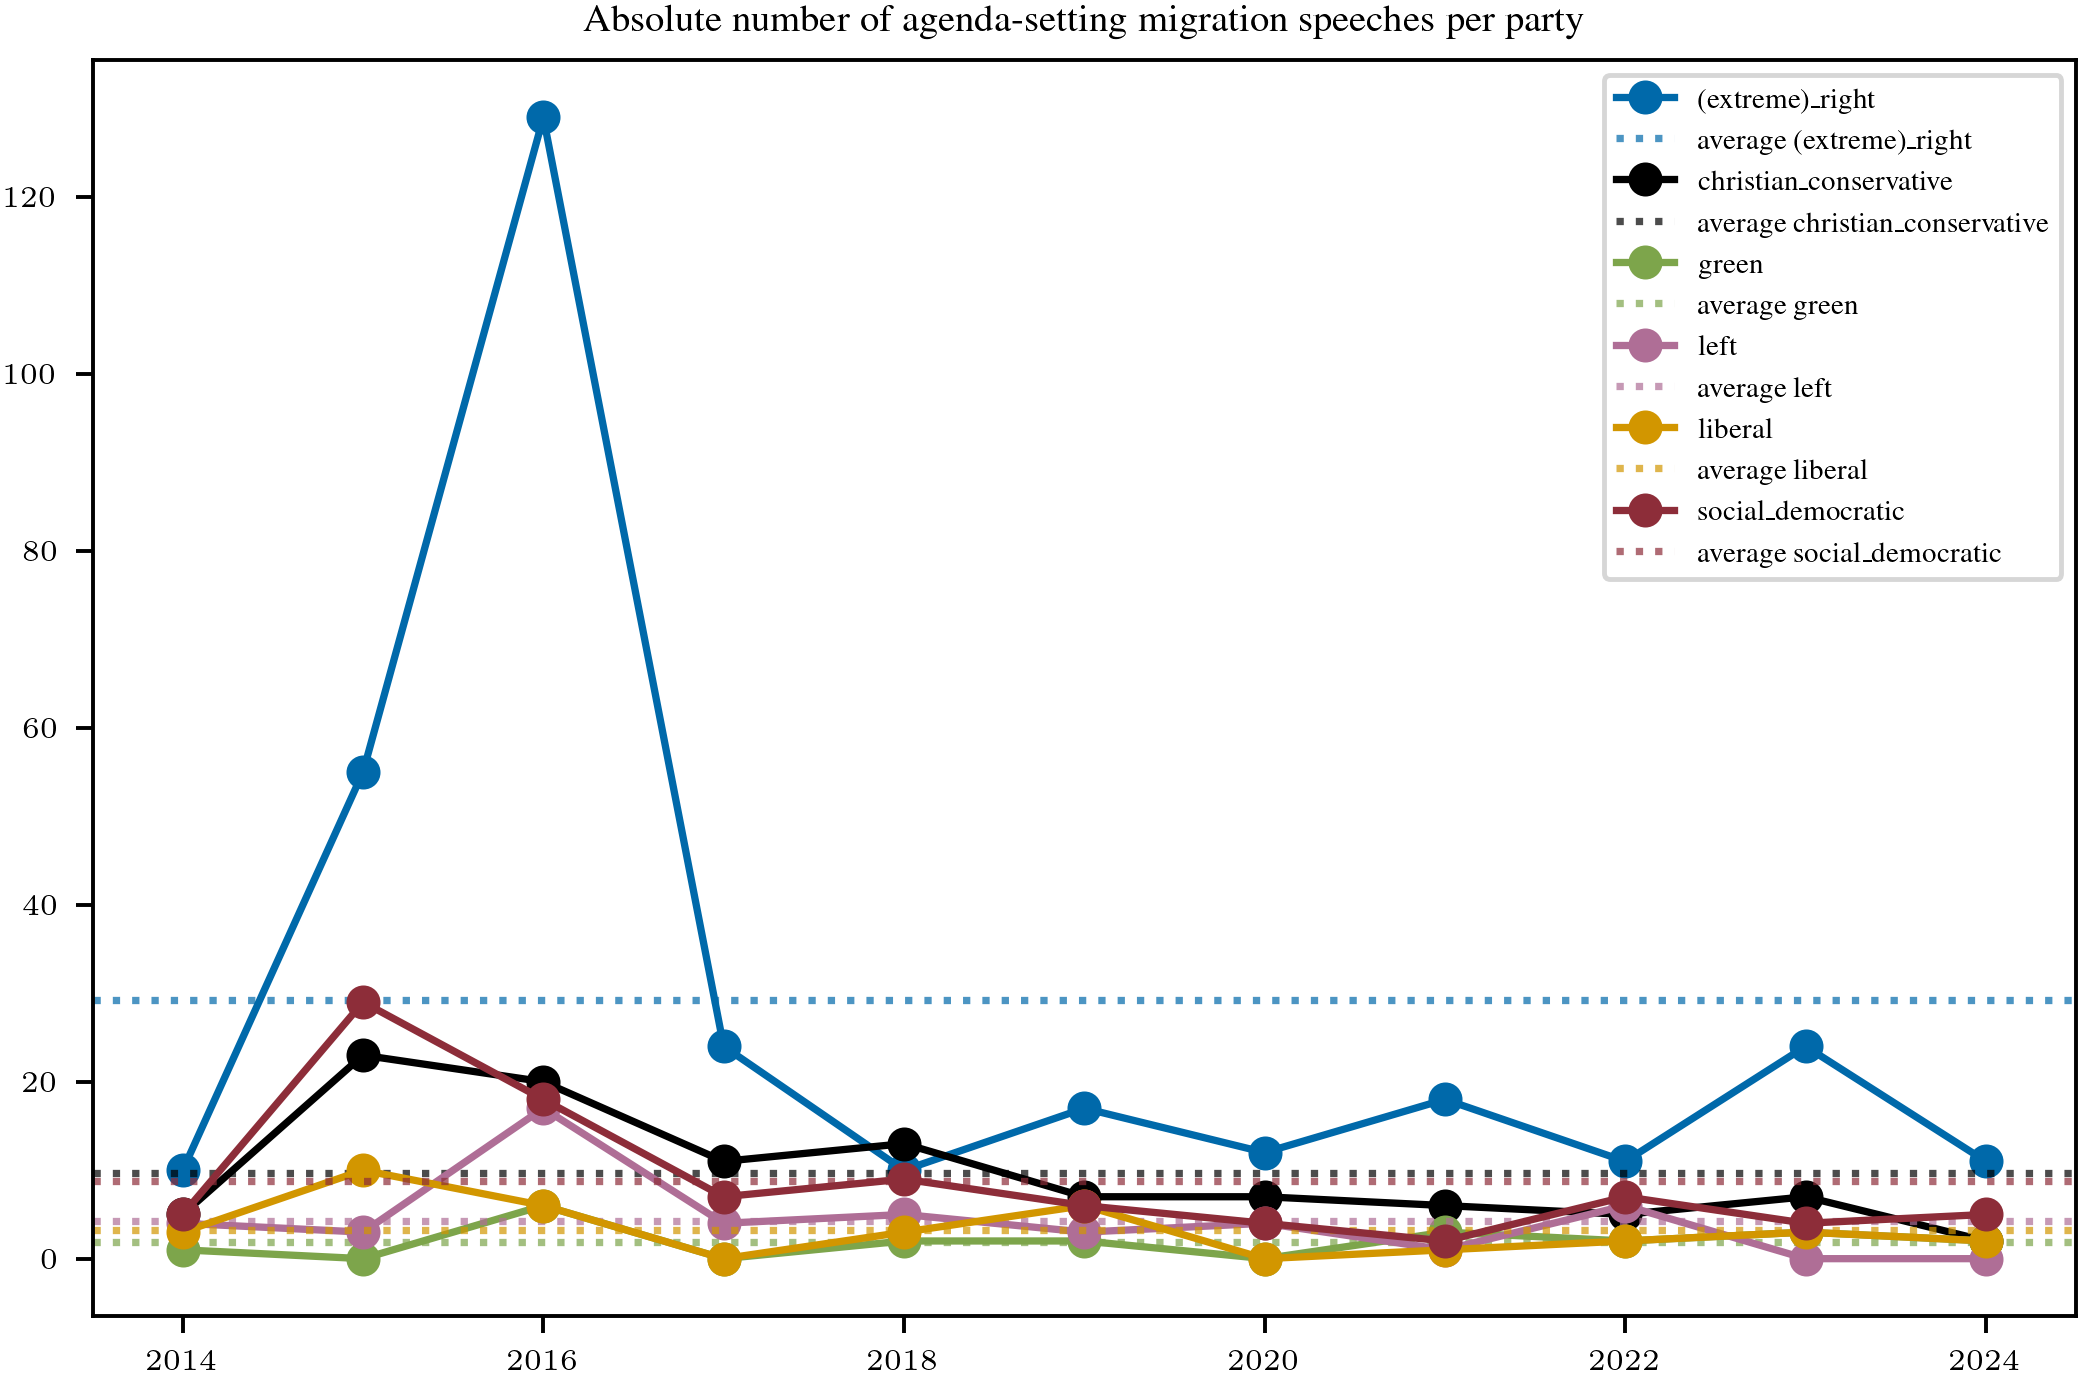

In [273]:
n_agenda_set_speeches_per_year = n_migration_speeches_per_party_agenda_setted.reset_index().melt("block")

plt.figure(figsize=(6, 4))
for block in n_agenda_set_speeches_per_year["block"].unique(): 
    color = colormap[block]
    props_this_block = n_agenda_set_speeches_per_year[n_agenda_set_speeches_per_year["block"] == block]
    plt.plot(props_this_block["year"], props_this_block["value"], label=block, marker="o", c=color)
    mean_over_years = np.mean(props_this_block["value"])

    plt.axhline(mean_over_years, c=color, alpha=0.7, linestyle=":", label="average "+block)

plt.title("Absolute number of agenda-setting migration speeches per party")
plt.legend()
plt.show()

In [274]:
print("Mean number of yearly agenda-setting migration speeches for non-extreme right parties", mean_n_agenda_set_speeches_per_year.drop("(extreme)_right").mean())
print("Std. dev of yearly agenda-setting migration speeches for non-extreme right parties", mean_n_agenda_set_speeches_per_year.drop("(extreme)_right").std())

Mean number of yearly agenda-setting migration speeches for non-extreme right parties 5.563636363636364
Std. dev of yearly agenda-setting migration speeches for non-extreme right parties 3.4229415603570903


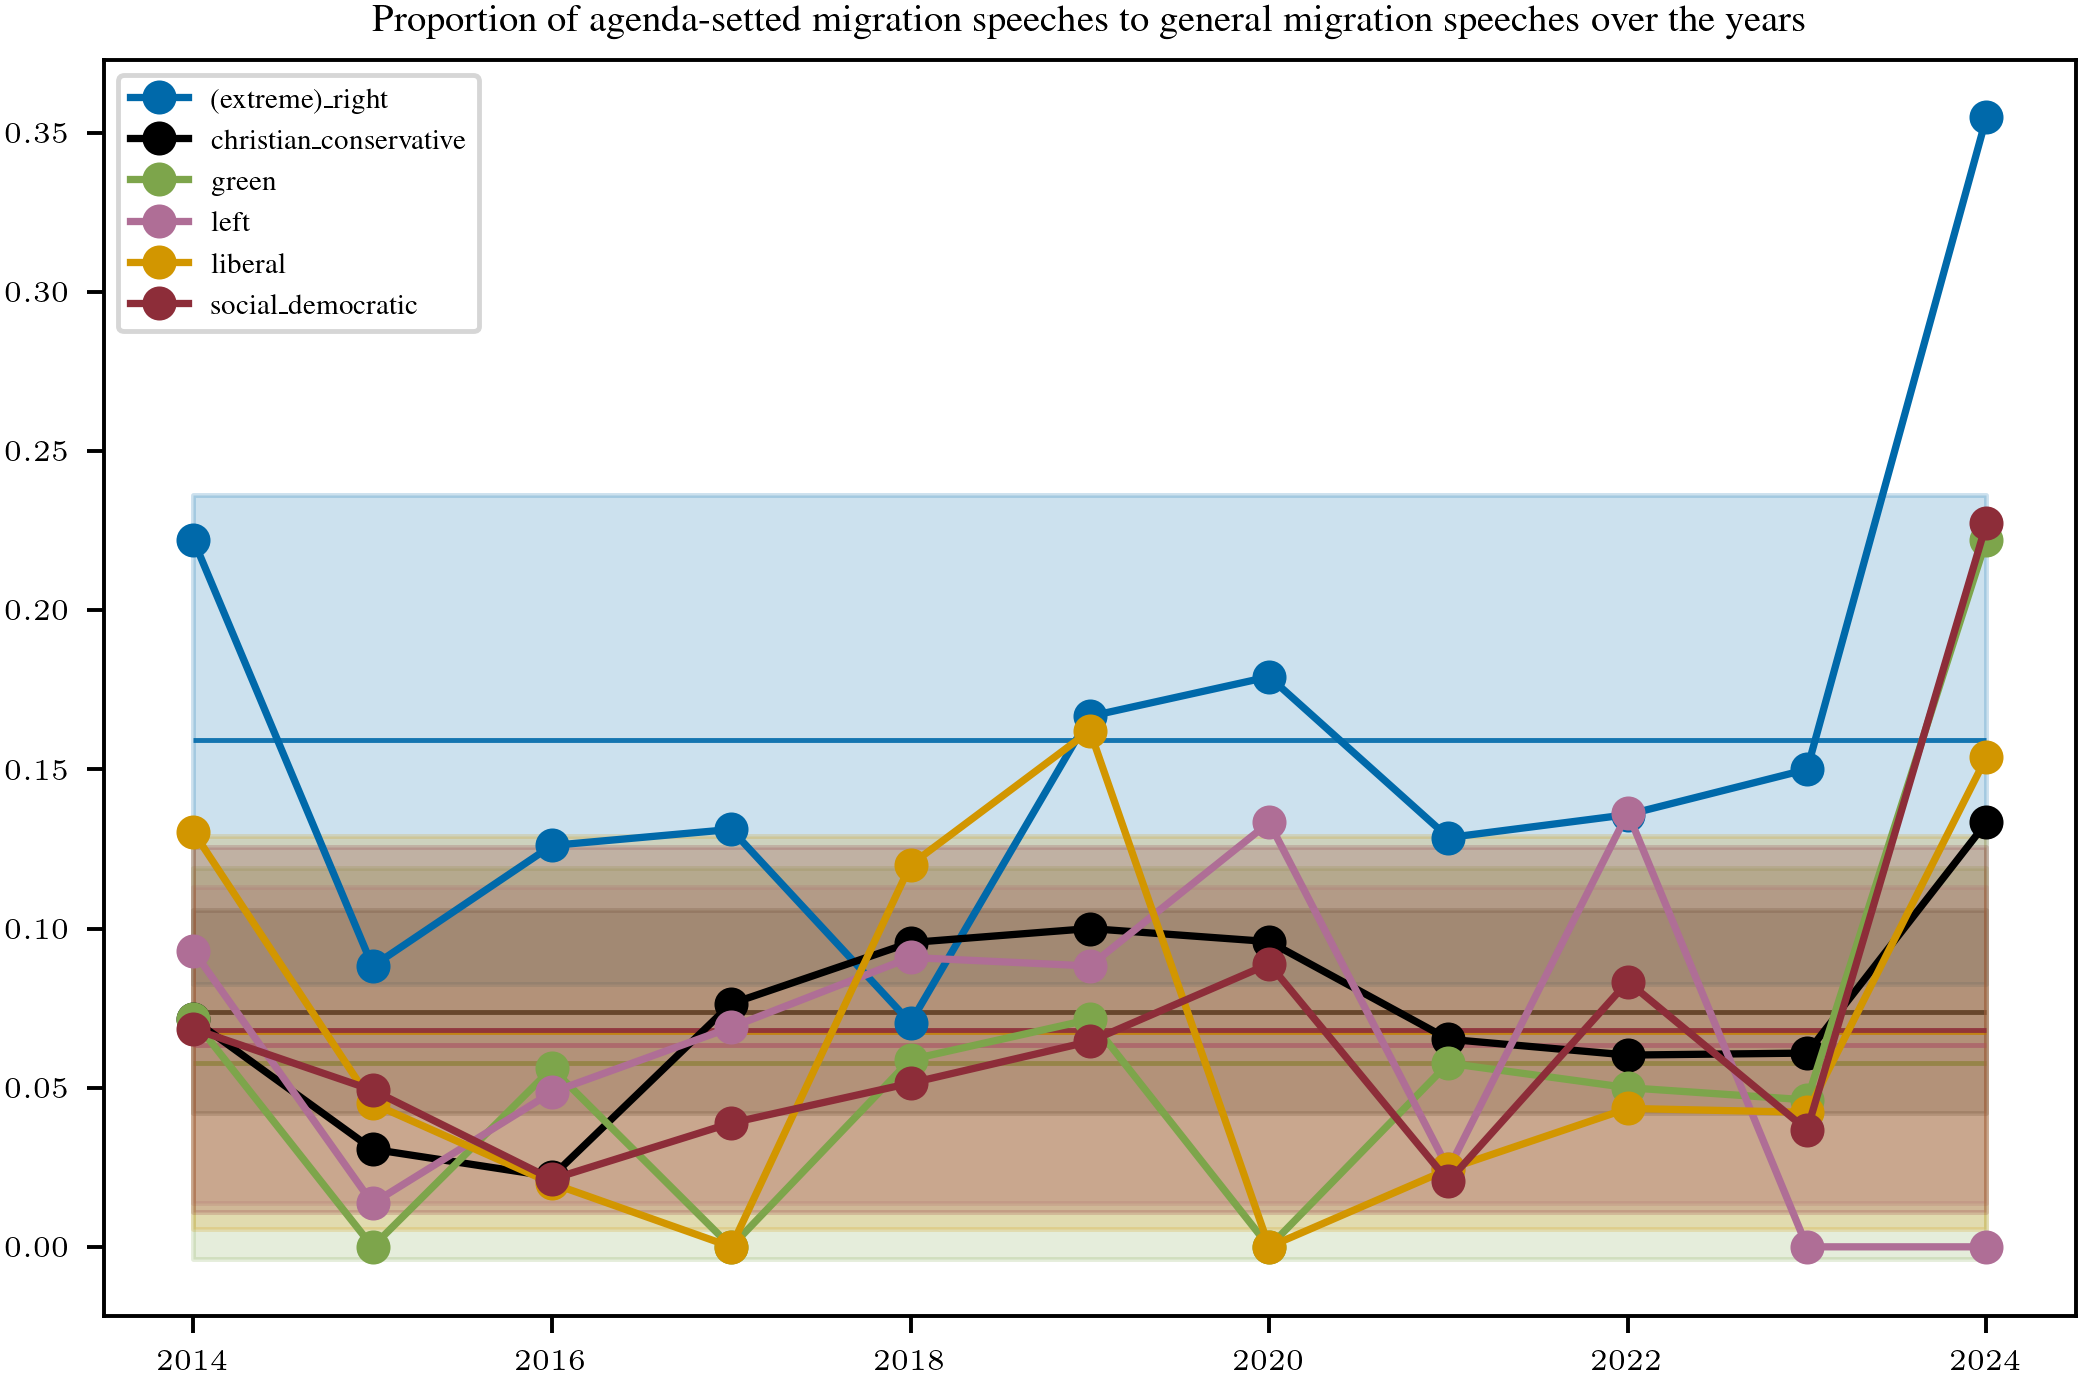

Horizontal lines mark mean over the years, shaded lines show standard dev. over the years


In [299]:
proportion_agenda_set_speeches = n_migration_speeches_per_party_agenda_setted/n_migration_speeches_per_party_total

# we have data in wide format (block, year_1, ..., year_n)
# but we want to have (block, year, value)
proportion_per_block = proportion_agenda_set_speeches.reset_index().melt(id_vars="block", var_name="year", value_name="value").groupby("block")
avg_proportion_per_block = proportion_per_block["value"].mean()
std_proportion_per_block = proportion_per_block["value"].std()

plt.figure(figsize=(6, 4))
for party, values in proportion_per_block: 
    color = colormap[party]
    mean = avg_proportion_per_block[party]
    std_dev = std_proportion_per_block[party]

    # print(values["year"].values)
    plt.plot(values["year"], values["value"], label=party, marker="o", c=color)
    # plt.axhline(mean, c=color, alpha=1, linestyle=":"
    plt.fill_between([2014, 2024], mean-std_dev, mean+std_dev, color=color, alpha=0.2)
    plt.fill_between([2014, 2024], mean, mean, color=color, alpha=0.9)

plt.title("Proportion of agenda-setted migration speeches to general migration speeches over the years")
plt.legend()
plt.show()
print("Horizontal lines mark mean over the years, shaded lines show standard dev. over the years")

In [300]:
avg_proportion_per_block

block
(extreme)_right           0.159365
christian_conservative    0.073789
green                     0.057620
left                      0.063403
liberal                   0.067413
social_democratic         0.068239
Name: value, dtype: float64

In [301]:
std_proportion_per_block

block
(extreme)_right           0.076865
christian_conservative    0.031889
green                     0.061342
left                      0.049753
liberal                   0.061714
social_democratic         0.057389
Name: value, dtype: float64

In [298]:
print("Mean proportion of yearly agenda-setting migration speeches for non-extreme right parties", avg_proportion_per_block.drop("(extreme)_right").mean())
print("Std. dev of yearly agenda-setting migration speeches for non-extreme right parties", avg_proportion_per_block.drop("(extreme)_right").std())

Mean proportion of yearly agenda-setting migration speeches for non-extreme right parties 0.06609264380906434
Std. dev of yearly agenda-setting migration speeches for non-extreme right parties 0.006012343394072131


=> proportion is significantly higher for extreme-right parties; for others, there is no evidence for different behaviour

For good measure, make sure the difference between parties is significant:

In [290]:
from scipy.stats import f_oneway

f_statistic, p_value = f_oneway(*[(proportions.value.tolist()) for party, proportions in proportion_per_block])

f_statistic_no_extreme_right, p_value_no_extreme_right = f_oneway(*[(proportions.value.tolist()) for block, proportions in proportion_per_block if not block == "(extreme)_right"])

print("With all parties:")
print(f"F-statistic: {f_statistic}")
print(f"P-value: {p_value}")
print()
print("Without extreme right parties:")
print(f"F-statistic: {f_statistic_no_extreme_right}")
print(f"P-value: {p_value_no_extreme_right}")

With all parties:
F-statistic: 4.816387803254966
P-value: 0.000909347686787818

Without extreme right parties:
F-statistic: 0.13847746380314574
P-value: 0.9672164019910994


## When do partys do agenda-setting?

In [260]:
# for each party, find one example of agenda setting: 
import re 

agenda_titles_with_agenda_setting = []
for party in df_final[party_column].unique(): 
    def clean_agenda_title(title): 
        # remove date from agenda item 
        title = title[:-10]
        # remove bracketed comments 
        title = re.sub(r'\(.*\)', '', title)
        # only keep letters and : or -
        title = re.sub(r'[^A-Za-z:\- ]+', '', title)
        title = title.strip()
        return title 

    agenda_items_that_party_did_agenda_setting = df_agenda_setting_candidates[(df_agenda_setting_candidates[final_topic_col] > final_threshold) & (df_agenda_setting_candidates[party_column] == party)]["agenda"].unique()

    for title in agenda_items_that_party_did_agenda_setting: 
        agenda_titles_with_agenda_setting.append({party_column: party, "cleaned": clean_agenda_title(title), "raw": title})

# now have dataframe with party, cleaned (cleaned agenda title), raw (full agenda title)
# => all titles of agenda items where that party agenda-set migration
agenda_titles_with_agenda_setting = pd.DataFrame(agenda_titles_with_agenda_setting)
agenda_titles_with_agenda_setting.drop_duplicates(subset=[party_column, "cleaned"], inplace=True)

In [261]:
from src.constants import TOPIC_LABELS, N_TOPICS, ORDER_BLOCK

In [262]:
topic_columns = [f"topic_{i}" for i in range(N_TOPICS)]

topic_scores_per_agenda = df_final[["agenda"] + topic_columns].groupby("agenda").mean()
top_topic_per_agenda = topic_scores_per_agenda.idxmax(axis=1).map(lambda topic_name: int(topic_name.split("_")[-1])).rename("top_topic_idx")

agenda_titles_with_agenda_setting = agenda_titles_with_agenda_setting.join(top_topic_per_agenda, "raw")

In [263]:
all_agenda_items = pd.DataFrame(top_topic_per_agenda)
all_agenda_items = all_agenda_items.join(agenda_titles_with_agenda_setting.set_index("raw")["block"])
agenda_set_party_one_hot = pd.get_dummies(all_agenda_items['block'])
all_agenda_items = all_agenda_items.join(agenda_set_party_one_hot)
all_agenda_items["n_agenda_set"] = ~(all_agenda_items['block'].isna())
all_agenda_items.drop("block", inplace=True, axis=1)

n_agenda_set_per_topic = all_agenda_items.groupby("top_topic_idx").sum()
n_agenda_set_per_topic["topic_name"] = TOPIC_LABELS

# blocks = df_final["block"].unique()
blocks = ORDER_BLOCK

First, in absolute numbers: what topics are most "disturbed" by agenda setting? 

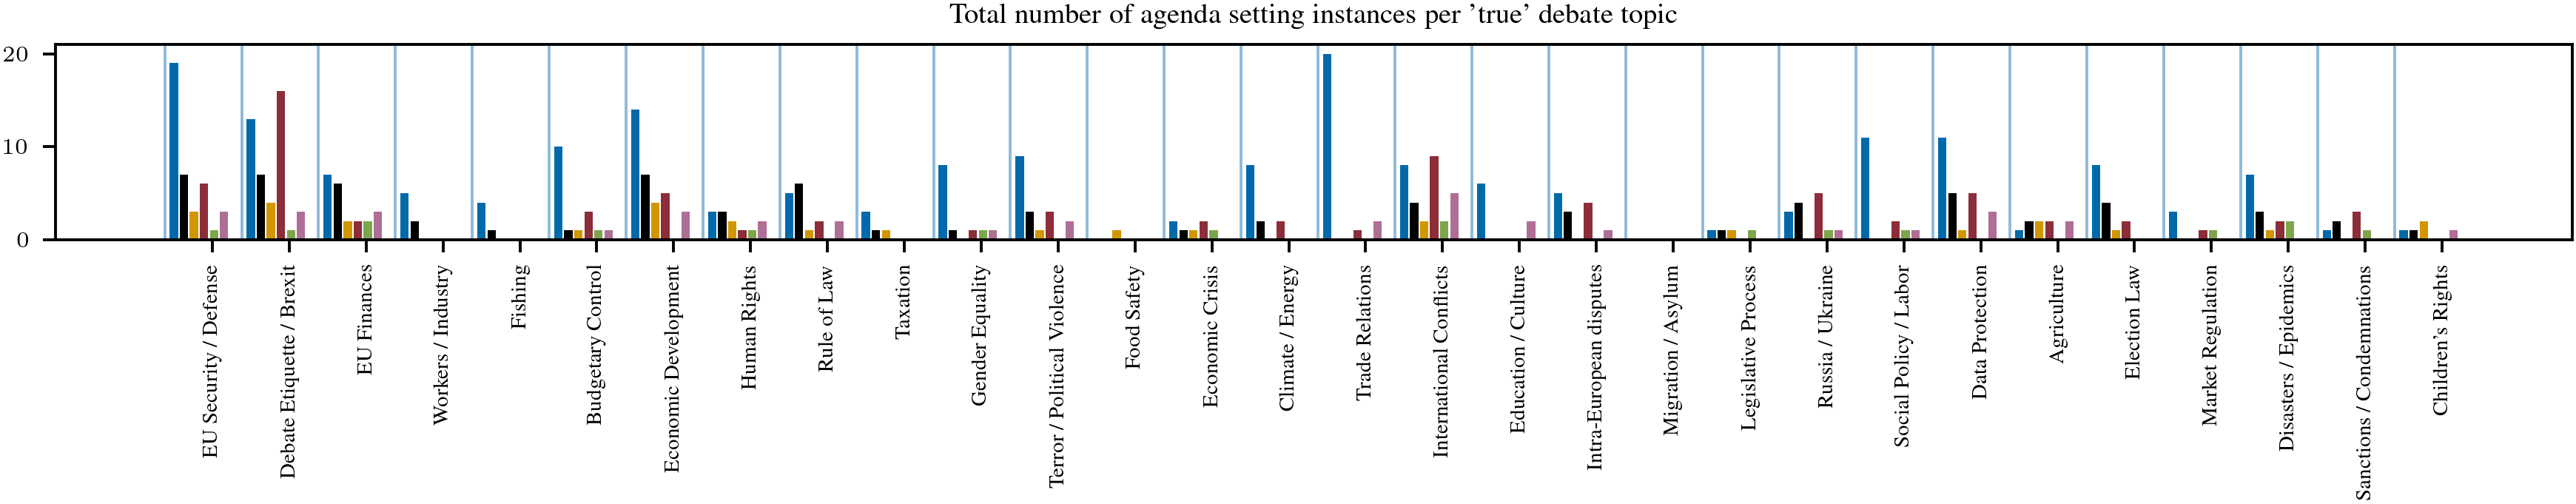

In [264]:
bar_width = 1.2
padding_width = 1
group_width = bar_width * len(blocks) + 1 + padding_width
X = np.arange(N_TOPICS) * group_width

plt.figure(figsize=(10, 2))
for i, block in enumerate(blocks): 
    plt.bar(X+i*bar_width, n_agenda_set_per_topic[block], label=block, color=colormap[block], width=bar_width-0.2)

    ax = plt.gca()

for x in X:
    ax.axvline(x - bar_width/2 - padding_width/2, linewidth=0.8, alpha=0.5, zorder=0)

plt.title("Total number of agenda setting instances per 'true' debate topic")
plt.xticks(X + group_width / 2, TOPIC_LABELS, rotation=90)
# plt.legend()
None

=> especially when others talk about trade relations, EU security, Econimic Development, and many others, the extreme right seems to hijack the debate and talk about migration instead

But what about the other parties that perform less agenda setting? When do they do it? 

For each block: what is their most frequent agenda setting topic?

In [265]:
for block in blocks: 
    most_frequent_agenda_setting_topic = agenda_titles_with_agenda_setting[agenda_titles_with_agenda_setting["block"] == block]["top_topic_idx"].value_counts(normalize=True).sort_values(ascending=False)
    top3topics = most_frequent_agenda_setting_topic.head(3)
    print(block, " ".join([f"'{TOPIC_LABELS[i]}' ({'%.3f' % top3topics[i]});" for i in top3topics.index]))

(extreme)_right 'Trade Relations' (0.102); 'EU Security / Defense' (0.097); 'Economic Development' (0.071);
christian_conservative 'EU Security / Defense' (0.091); 'Debate Etiquette / Brexit' (0.091); 'Economic Development' (0.091);
liberal 'Debate Etiquette / Brexit' (0.129); 'Economic Development' (0.129); 'EU Security / Defense' (0.097);
social_democratic 'Debate Etiquette / Brexit' (0.203); 'International Conflicts' (0.114); 'EU Security / Defense' (0.076);
green 'EU Finances' (0.118); 'Disasters / Epidemics' (0.118); 'International Conflicts' (0.118);
left 'International Conflicts' (0.132); 'EU Finances' (0.079); 'Debate Etiquette / Brexit' (0.079);


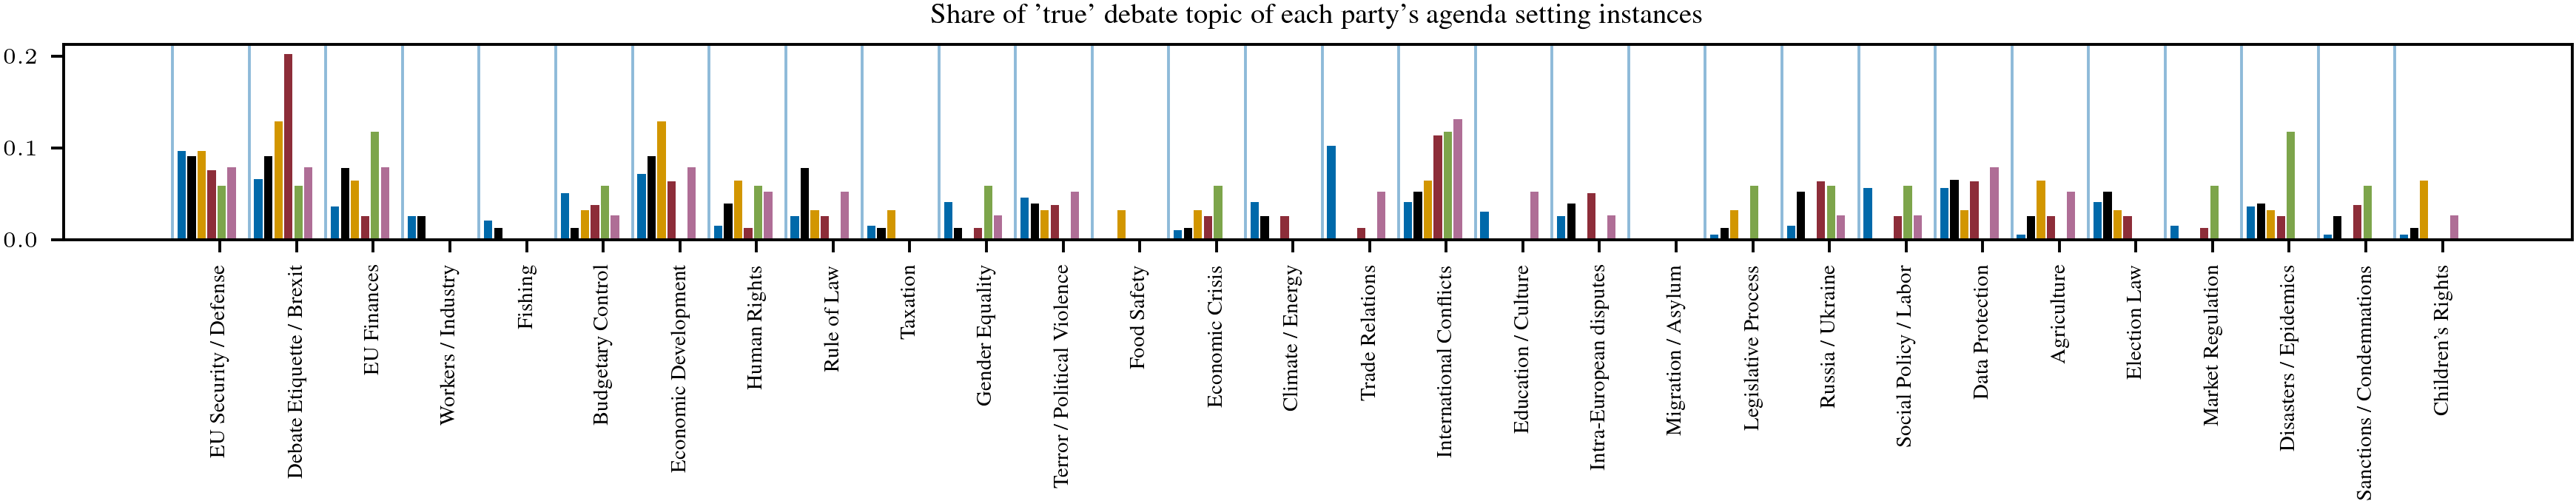

In [266]:
bar_width = 1.2
padding_width = 1
group_width = bar_width * len(blocks) + 1 + padding_width
X = np.arange(N_TOPICS) * group_width

plt.figure(figsize=(10, 2))
for i, block in enumerate(blocks): 
    # agendas_with_agenda_setting[agendas_with_agenda_setting["block"] == block]["top_topic_idx"]
    value_counts_topics = np.zeros(N_TOPICS)
    value_counts_topics_ = agenda_titles_with_agenda_setting[agenda_titles_with_agenda_setting["block"] == block]["top_topic_idx"].value_counts(normalize=True)
    value_counts_topics[value_counts_topics_.index] = value_counts_topics_.values

    plt.bar(X+i*bar_width, value_counts_topics, label=block, color=colormap[block], width=bar_width-0.2)

    ax = plt.gca()

for x in X:
    ax.axvline(x - bar_width/2 - padding_width/2, linewidth=0.8, alpha=0.5, zorder=0)

plt.title("Share of 'true' debate topic of each party's agenda setting instances")
plt.xticks(X + group_width / 2, TOPIC_LABELS, rotation=90)
# plt.legend()
None

(extreme)_right: 'Trade Relations', 'EU Security / Defense' 

christian_conservative + liberal: 'EU Security / Defense', 'Debate Etiquette / Brexit', 'Economic Development'

social_democratic + left + green: 'EU Finances' (0.118); 'Disasters / Epidemics', 'International Conflicts' (0.118); 'Debate Etiquette / Brexit' (0.203);

=> right wings bring up migration when talking about international relations 
=> parties from the other side of the spectrum bring it up rather in humanitarian conflict situations

In [267]:
agenda_titles_with_agenda_setting

,block,cleaned,raw,top_topic_idx
0,green,EU-Egypt strategic and comprehensive partnersh...,17. EU-Egypt strategic and comprehensive partn...,7
1,green,The repressive environment in Afghanistan incl...,20.2. The repressive environment in Afghanista...,28
2,green,Order of business,11. Order of business2023-11-08,20
3,green,This is Europe - Debate with the President of ...,5. This is Europe - Debate with the President ...,21
4,green,One-minute speeches on matters of political im...,14. One-minute speeches on matters of politica...,1
...,...,...,...,...
496,left,The EUs role in the Middle East peace process,9.8. The EU's role in the Middle East peace pr...,16
497,left,Mass graves of the missing persons of Ashia at...,3.3. Mass graves of the missing persons of Ash...,11
498,left,Mobilisation of the Contingency Margin in,11.3. Mobilisation of the Contingency Margin i...,2
499,left,Shortage of funding for the World Food Program...,15. Shortage of funding for the World Food Pro...,16


In [268]:
example_agendas = [
    ('(extreme)_right', 'EU Security / Defense'), 
    # ('christian_conservative', 'EU Security / Defense'),
    # ('liberal', 'Economic Development'), 
    # ('social_democratic', 'Debate Etiquette / Brexit'),  
    # ('green', 'Disasters / Epidemics'),  
    ('left', 'International Conflicts'),  
]

for block, topic in example_agendas: 
    topic_idx = TOPIC_LABELS.index(topic)
    example = agenda_titles_with_agenda_setting[(agenda_titles_with_agenda_setting["block"] == block) & (agenda_titles_with_agenda_setting["top_topic_idx"] == topic_idx)].head(4)
    print_agendas(example["raw"])


4. Strengthening European Defence in a volatile geopolitical landscape - Implementation of the common foreign and security policy – annual report 2023 - Implementation of the common security and defence policy – annual report 2023 (joint debate - European security and defence)2024-02-28
Parties talking about migration: (extreme)_right (1)
[ ] 4: Manfred Weber (PPE - christian_conservative) [0% migration]
	Madam President, President von der Leyen, Council, dear colleagues, as EPP, we are, first of all, happy to have the debate today. Such an upgraded top-level debate about the Defence Union. EPP was asking for this for a long period of time and that’s why it is good to have it. For us, first of all, I want to underline that the subject itself is not innovative at all. I said it already in my last speech: in 1945, Adenauer, Schuman, De Gasperi started with the Defence Union. The French Parliament rejected, De Gasperi had tears in his eyes after it failed in the French Parliament. The ide